In [68]:
import numpy as np
import pandas as pd
import requests
from datetime import datetime

In [69]:
with open('pass.txt', 'r') as f:
    lines = f.readlines()

pwd = lines[0].strip()
CLIENT_ID = lines[1].strip()
SECRET_ID = lines[2].strip()

In [70]:
data = {
    'grant_type': 'password',
    'username': 'eJechtion4',
    'password': pwd
}
headers = {"User-Agent": "MyAPI/1.0.0"}
auth = requests.auth.HTTPBasicAuth(CLIENT_ID, SECRET_ID)

res = requests.post('https://www.reddit.com/api/v1/access_token',
auth = auth, data = data, headers = headers)

TOKEN = res.json()["access_token"]
headers["Authorization"] = f'bearer {TOKEN}'


In [71]:
res = requests.get("https://oauth.reddit.com/r/AskReddit/hot", headers = headers, params= {'limit': '100'})

In [72]:
# Extract relevant data from API response
data = []
for post in res.json()["data"]["children"]:
    post_date = datetime.utcfromtimestamp(post["data"]["created_utc"]).strftime('%Y-%m-%d %H:%M:%S')
    data.append({
        "post_id": post["data"]["id"],
        "post_title": post["data"]["title"],
        "post_text": post["data"]["selftext"],
        "post_date": post_date,
        "author": post["data"]["author"],
        "subreddit": post["data"]["subreddit"],
        "upvotes": post["data"]["ups"],
        "downvotes": post["data"]["downs"],
        "num_comments": post["data"]["num_comments"]
    })

# Create pandas DataFrame from extracted data
df = pd.DataFrame(data)

In [73]:
df.drop_duplicates(subset=['post_title', 'post_text'], inplace=True) #drop duplicates


In [74]:
df

,post_id,post_title,post_text,post_date,author,subreddit,upvotes,downvotes,num_comments
0,11kyi0b,Which one of these charities should AskReddit ...,It's time for the community to vote on which c...,2023-03-07 12:49:22,-eDgAR-,AskReddit,128,0,6
1,11nsw9x,People who voted for Biden. How do feel he is ...,,2023-03-10 15:58:32,Odd_Hedgehog8123,AskReddit,2064,0,4278
2,11nqnfw,What slang term are dead give away to where yo...,,2023-03-10 14:27:40,Sam_21000,AskReddit,469,0,2082
3,11nmzgf,What food has the worst texture?,,2023-03-10 11:48:32,Lille_Ana,AskReddit,738,0,2061
4,11nqkcm,"If, instead of men, women were inherently phys...",,2023-03-10 14:23:57,Tototorrin,AskReddit,406,0,701
...,...,...,...,...,...,...,...,...,...
96,11nx6v7,What's the best rhyming couplet in all of rap ...,,2023-03-10 18:43:48,99thLuftballon,AskReddit,3,0,4
97,11nx6gj,For people who've found their partners cheatin...,,2023-03-10 18:43:20,cknyakina,AskReddit,3,0,5
98,11nx3u2,Which animal would you want to gain the intell...,,2023-03-10 18:40:25,Recycled_Matter,AskReddit,3,0,18
99,11nsrxn,What do people spend money on that you think i...,,2023-03-10 15:53:39,Gualla47,AskReddit,4,0,49


# NLP Start


In [75]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [76]:
# define stop words
stop_words = set(stopwords.words('english'))

# instantiate stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# define preprocessing pipeline
def preprocess_text(text):
    # tokenize text
    tokens = word_tokenize(text)

    # remove stop words
    tokens = [token for token in tokens if token not in stop_words]

    # stem and lemmatize tokens
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in stemmed_tokens]

    # return preprocessed text as a string
    return " ".join(lemmatized_tokens)




In [77]:
# apply preprocessing pipeline to text data
df["preprocessed_text"] = df["post_title"].apply(preprocess_text)

In [78]:
df["preprocessed_text"] # check if stemming worked

0      which one chariti askreddit support 15th anniv...
1                          peopl vote biden . how feel ?
2                       what slang term dead give away ?
3                               what food worst textur ?
4      if , instead men , woman inher physic stronger...
                             ...                        
96                what 's best rhyme couplet rap music ?
97     for peopl 've found partner cheat , made go ba...
98     which anim would want gain intellig abil speak...
99            what peopl spend money think unnecessari ?
100                                 when give up/settl ?
Name: preprocessed_text, Length: 101, dtype: object

# Vectorize data


In [79]:
from sklearn.feature_extraction.text import CountVectorizer

# create a CountVectorizer object
vectorizer = CountVectorizer(stop_words='english', max_features=1000)

# fit and transform the preprocessed_text column
X = vectorizer.fit_transform(df["preprocessed_text"])

# create a new dataframe with the countvectorizer output
cv_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# concatenate the cv_df dataframe with the original dataframe
df_final = pd.concat([df, cv_df], axis=1)



In [80]:
df_final

,post_id,post_title,post_text,post_date,author,subreddit,upvotes,downvotes,num_comments,preprocessed_text,...,whi,wikipedia,william,wish,woman,word,work,world,worst,zombi
0,11kyi0b,Which one of these charities should AskReddit ...,It's time for the community to vote on which c...,2023-03-07 12:49:22,-eDgAR-,AskReddit,128,0,6,which one chariti askreddit support 15th anniv...,...,0,0,0,0,0,0,0,0,0,0
1,11nsw9x,People who voted for Biden. How do feel he is ...,,2023-03-10 15:58:32,Odd_Hedgehog8123,AskReddit,2064,0,4278,peopl vote biden . how feel ?,...,0,0,0,0,0,0,0,0,0,0
2,11nqnfw,What slang term are dead give away to where yo...,,2023-03-10 14:27:40,Sam_21000,AskReddit,469,0,2082,what slang term dead give away ?,...,0,0,0,0,0,0,0,0,0,0
3,11nmzgf,What food has the worst texture?,,2023-03-10 11:48:32,Lille_Ana,AskReddit,738,0,2061,what food worst textur ?,...,0,0,0,0,0,0,0,0,1,0
4,11nqkcm,"If, instead of men, women were inherently phys...",,2023-03-10 14:23:57,Tototorrin,AskReddit,406,0,701,"if , instead men , woman inher physic stronger...",...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,11nx6v7,What's the best rhyming couplet in all of rap ...,,2023-03-10 18:43:48,99thLuftballon,AskReddit,3,0,4,what 's best rhyme couplet rap music ?,...,0,0,0,0,0,0,0,0,0,0
97,11nx6gj,For people who've found their partners cheatin...,,2023-03-10 18:43:20,cknyakina,AskReddit,3,0,5,"for peopl 've found partner cheat , made go ba...",...,0,0,0,0,0,0,0,0,0,0
98,11nx3u2,Which animal would you want to gain the intell...,,2023-03-10 18:40:25,Recycled_Matter,AskReddit,3,0,18,which anim would want gain intellig abil speak...,...,0,0,0,0,0,0,0,0,0,0
99,11nsrxn,What do people spend money on that you think i...,,2023-03-10 15:53:39,Gualla47,AskReddit,4,0,49,what peopl spend money think unnecessari ?,...,0,0,0,0,0,0,0,0,0,0


# Data Exploration (EDA)

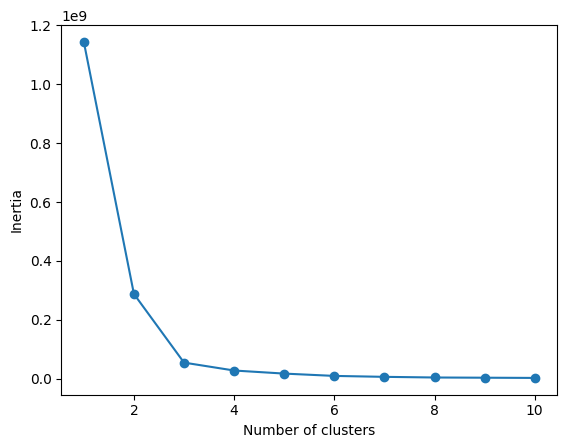

In [81]:
#Use unspervised learning methods to categorize each post, in this case we will be using KMEANs
#First we will use the elbow method in order to determine the ideal number of clusters for our data
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# concatenate the vectorized text features, upvotes, and number of comments
df_elbow = df_final.drop(["post_id", "post_title", "post_text", "post_date", "author", "subreddit", "preprocessed_text"], axis=1)

# perform k-means clustering for different number of clusters and calculate the inertia for each
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_elbow)
    inertia.append(kmeans.inertia_)

# plot the elbow curve to visualize the results
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


From the elbow method it would seem that the ideal number of clusters for out data set is 3.

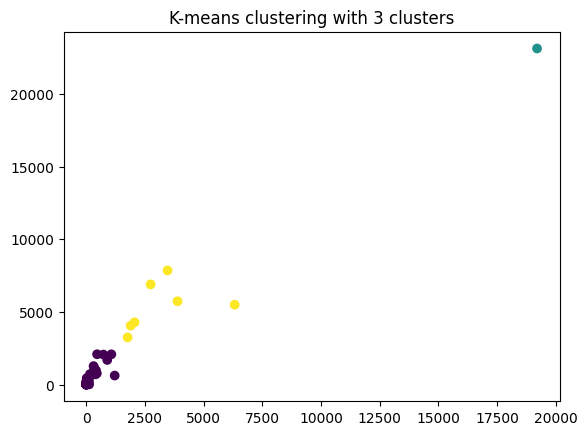

In [82]:
# Perform K-means clustering with 3 clusters
kmeans_3 = KMeans(n_clusters=3)
kmeans_3.fit(df_elbow)
labels_3 = kmeans_3.labels_

# Visualize the clusters
plt.scatter(df_elbow['upvotes'], df_elbow['num_comments'], c=labels_3)
plt.title("K-means clustering with 3 clusters")
plt.show()


There seems to be an outlier that is impacting our results. Beacuse of this we will be removing the outlier.

# Removing Outlier and reperforming Kmeans


In [83]:
outlier = df_elbow.loc[df_elbow['num_comments'].idxmax()]# Find the outlier based on the graph it seems to be at the max
print(outlier)

upvotes         19196
downvotes           0
num_comments    23125
000                 0
100                 0
                ...  
word                0
work                0
world               0
worst               0
zombi               0
Name: 9, Length: 301, dtype: int64


In [84]:
# Find the index of the row corresponding to the outlier post
outlier_index = df_final[df_final["post_id"] == "11mv4dc"].index[0]

# Drop the row from the dataframe
df_final_no_outlier = df_final.drop(outlier_index)


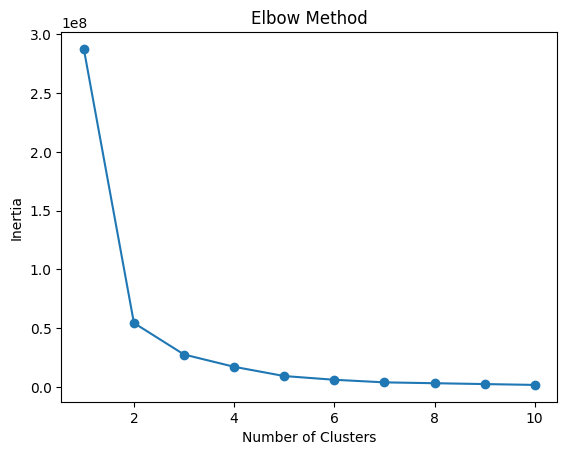

In [85]:
df_elbow_clean = df_final_no_outlier.drop(["post_id", "post_title", "post_text", "post_date", "author", "subreddit", "preprocessed_text"], axis=1)


# Perform elbow method on updated data frame
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_elbow_clean)
    inertias.append(kmeans.inertia_)

# Plot elbow method results
plt.plot(range(1, 11), inertias,marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

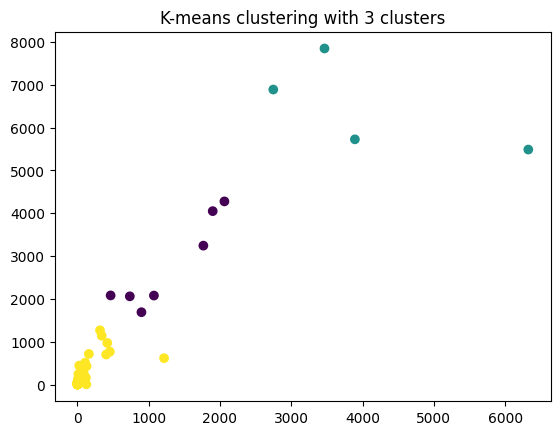

In [86]:
# Perform K-means clustering with 3 clusters
kmeans_3 = KMeans(n_clusters=3)
kmeans_3.fit(df_elbow_clean)
labels_3 = kmeans_3.labels_

# Visualize the clusters
plt.scatter(df_elbow_clean['upvotes'], df_elbow_clean['num_comments'], c=labels_3)
plt.title("K-means clustering with 3 clusters")
plt.show()
